# Load Module

## Preparation

git clone https://github.com/zalandoresearch/fashion-mnist.git


cd fashion-mnist

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import keras

import random
from tensorflow.contrib.tensorboard.plugins import projector
from utils import mnist_reader

/home/hf/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.4.0'

# Load Data

In [3]:
train_images, train_labels = mnist_reader.load_mnist('data/fashion', kind='train')
test_images,test_labels = mnist_reader.load_mnist('data/fashion', kind='t10k')


In [4]:
print("Training images shape: {shape}".format(shape=train_images.shape))
print("Training labels shape: {shape}".format(shape=train_labels.shape))

# Shapes of test set
print("Test images shape: {shape}".format(shape=test_images.shape))
print("Test labels shape: {shape}".format(shape=test_labels.shape))

Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (10000, 784)
Test labels shape: (10000,)


## Create a dictionary of integer labels 

In [5]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Data Preprocession

In [6]:
num_classes = 10
x_train = train_images.reshape([-1,28,28,1])
x_test= test_images.reshape([-1,28,28,1])
y_train = keras.utils.to_categorical(np.ravel(train_labels), num_classes)
y_test = keras.utils.to_categorical(np.ravel(test_labels), num_classes)

In [7]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

('x_train shape: ', (60000, 28, 28, 1))
('x_test shape: ', (10000, 28, 28, 1))
('y_train shape: ', (60000, 10))
('y_test shape: ', (10000, 10))


## Plot data

In [8]:
image_shape = (28,28)
def plot_image(images, labels, labels_pred = None):
    fig, axes = plt.subplots(3,3)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        if labels_pred is None: 
            xlabel = 'True: {0}'.format(labels[i])
        else: 
            xlabel = 'True: {0}, Pred: {1}'.format(labels[i],labels_pred[i])            
        ax.set_xlabel(xlabel)
        ax.grid(False)      
        ax.set_yticks([])
        ax.set_yticks([])
        
    plt.show()

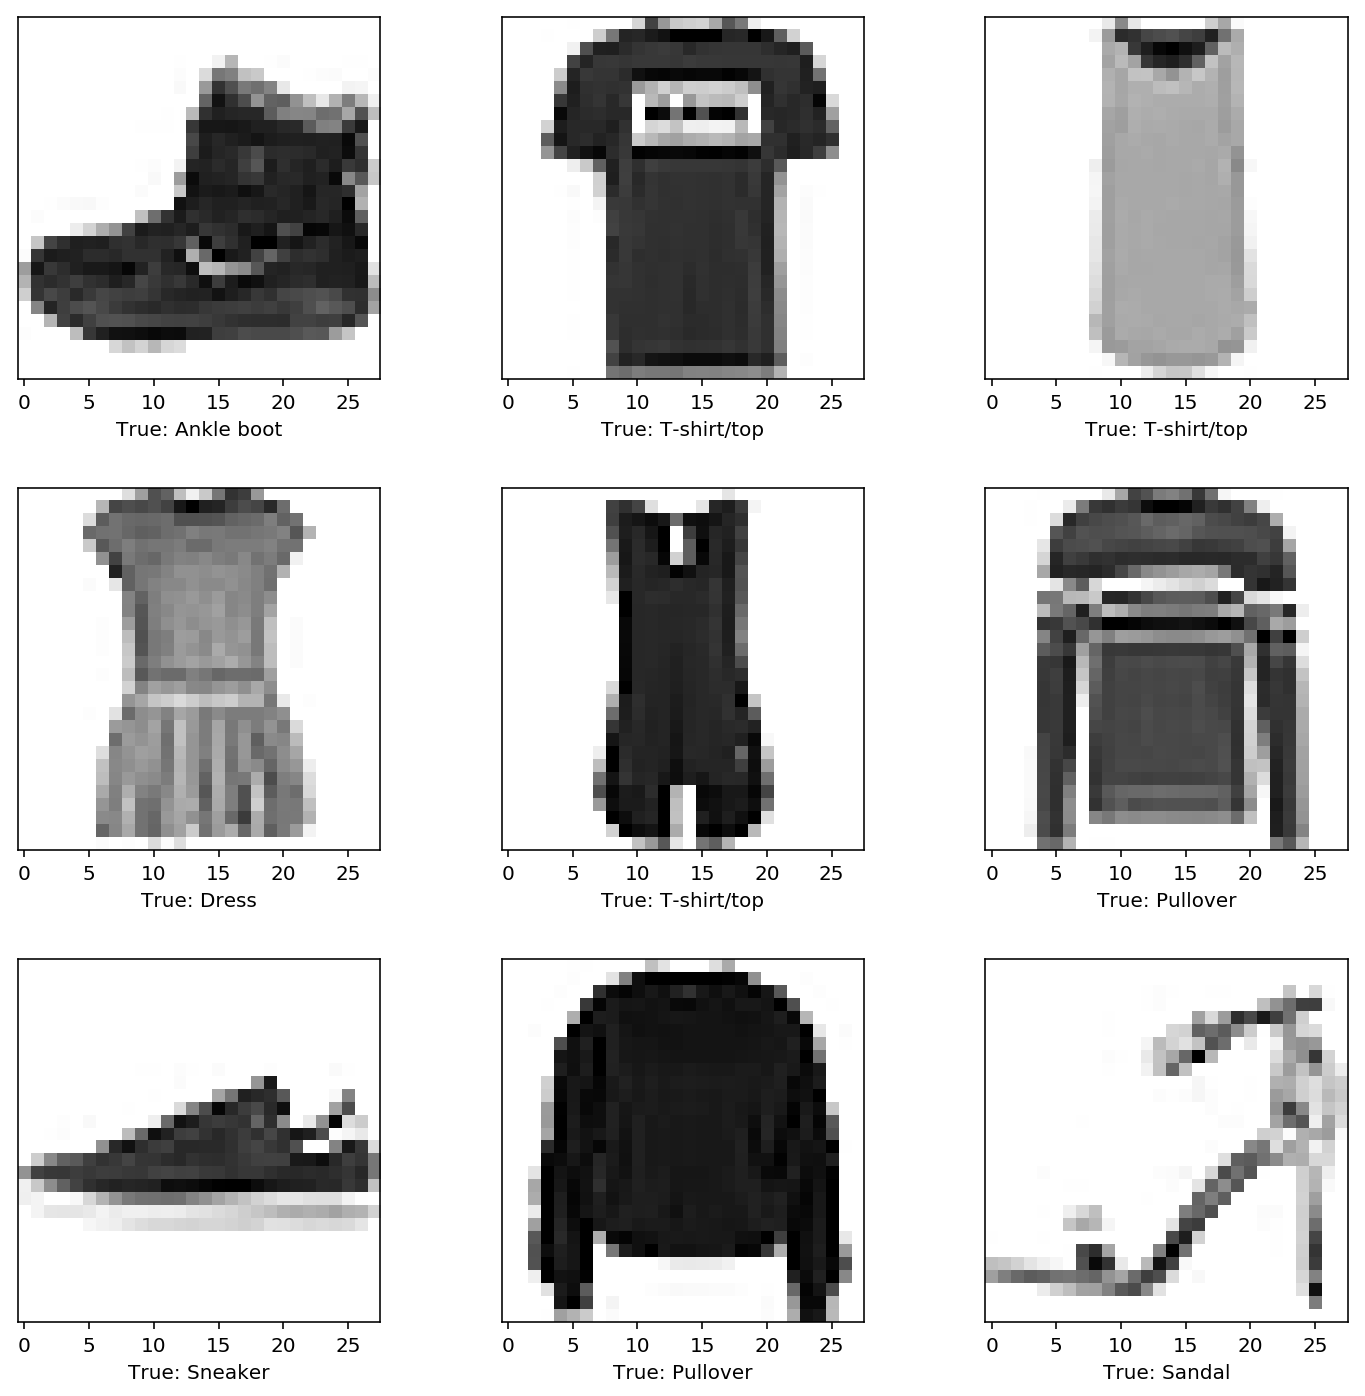

In [9]:
images = x_train[:9,:,:,:]
labels = [label_dict[x] for x in train_labels[:9]]
word_labels = [label_dict[x] for x in train_labels]
plot_image(images = images, labels = labels)

# Build Convolutional Neural Network with Tensorflow

## Set parameters

In [10]:
# Network parameters
n_hidden_1 = 256 # Units in first hidden layer
n_hidden_2 = 128 # Units in second hidden layer
n_input = 784 # Fashion MNIST data input (img shape: 28*28)
n_classes = 10 # Fashion MNIST total classes (0-9 digits)
image_size = 28
channel_size = 1
n_samples =  x_train.shape[0]

filter_size1 = 512
filter_size2 = 128
filter_size3 = 32

sigma = 1e-3
learning_rate = 0.01

LOG_DIR = 'projector'

path_to_fmnist_sprites = os.path.join(LOG_DIR,'sprites.png')
path_to_fmnist_metadata = os.path.join(LOG_DIR,'metadata.tsv')

In [11]:
def variable_summaries(var):
    '''attach a lot of summaries to a tensorboard'''
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean',mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('seddev',stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram',var)

In [12]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None,image_size, image_size,channel_size])
    y = tf.placeholder(tf.float32, [None, n_classes])
    tf.summary.image('input',x,10)

In [13]:
def conv2d(x,w):
    return tf.nn.conv2d(x,w, strides=[1,1,1,1],padding ='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x, ksize = [1,2,2,1],strides = [1,2,2,1],padding ='SAME')

def avgpool2d(x):
    
    return tf.reduce_mean(x,[1,2])

In [14]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer,[-1,num_features])
    #now the shape should be [num_images, img_height * img_width*num_channels]
    return layer_flat, num_features

In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.1))


def new_biases(length):
    return tf.Variable(tf.constant(0.01, shape=[length]))

In [16]:
with tf.variable_scope('conv1'):
    #weights shape: [height, weight, channels, number of filters]
    w_conv1 = tf.Variable(new_weights([3,3,1,filter_size1]),name = 'w1')
    b_conv1 = tf.Variable(new_biases(length = filter_size1),name = 'b1')
    variable_summaries(w_conv1)
    variable_summaries(b_conv1)
    
    z1 = tf.add(conv2d(x,w_conv1),b_conv1)
    batch_mean1, batch_var1 = tf.nn.moments(z1,[0])
    scale1 = tf.Variable(tf.ones([filter_size1]))
    beta1 = tf.Variable(tf.zeros([filter_size1]))
    bn1 = tf.nn.batch_normalization(z1,batch_mean1, batch_var1, beta1, scale1, sigma)
    
    a1 = tf.nn.relu(bn1)
    d1 = tf.nn.dropout(a1,keep_prob = 0.8)
    print(d1.get_shape())

(?, 28, 28, 512)


In [17]:
with tf.variable_scope('conv2'):
    #weights shape: [height, weight, channels, number of filters]
    w_conv2 = tf.Variable(new_weights([3,3,512,filter_size2]),name ='w2')
    b_conv2 = tf.Variable(new_biases(length = filter_size2),name ='b2')
    variable_summaries(w_conv2)
    variable_summaries(b_conv2)
    
    z2 = tf.add(conv2d(d1,w_conv2),b_conv2)
    batch_mean2, batch_var2 = tf.nn.moments(z2,[0])
    scale2 = tf.Variable(tf.ones([filter_size2]))
    beta2 = tf.Variable(tf.zeros([filter_size2]))
    bn2 = tf.nn.batch_normalization(z2,batch_mean2, batch_var2, beta2, scale2, sigma)
    
    a2 = tf.nn.relu(bn2)
    p2 = avgpool2d(a2)
    

In [18]:
# Flatten Convolution layer
layer_flat, num_features = flatten_layer(p2)


In [19]:
#Fully connected Layer
with tf.variable_scope('fully_connected'):
    w_fc = tf.Variable(new_weights([num_features, 10]), name = 'w3')
    b_fc = tf.Variable(new_biases(length = 10), name= 'b3')
    variable_summaries(w_fc)
    variable_summaries(b_fc)
    
    z4 = tf.add(tf.matmul(layer_flat,w_fc),b_fc)
    d4 = tf.nn.dropout(z4,keep_prob = 0.8)
    
    Y = tf.nn.softmax(d4)
    tf.summary.histogram('fc_layer',Y)

In [20]:
#cross entropy
with tf.name_scope('loss'):
#     global_step = tf.Variable(0, trainable=False)
#     starter_learning_rate = 0.1
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step ,
#                                                100, 0.96,staircase = True)

    global_step = tf.Variable(0, trainable=False)
    boundaries = [100, 200]
    values = [0.5, 0.1, 0.01]
    learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Y, labels = y)
    cost = tf.reduce_mean(cross_entropy)
#     optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    optimizer = (
        tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step = global_step))
    tf.summary.scalar('loss',cost)

In [21]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

# Create Visualization 

In [22]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run(session = sess)

In [23]:
train_writer = tf.summary.FileWriter(os.path.join(LOG_DIR,'train'), sess.graph)
test_writer = tf.summary.FileWriter(os.path.join(LOG_DIR,'test'), sess.graph)
summary_writer = tf.summary.FileWriter(LOG_DIR,sess.graph)

merged = tf.summary.merge_all()

## Create Sprite Image

In [24]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    """ Makes black white, and white black """
    return 1-mnist_digits

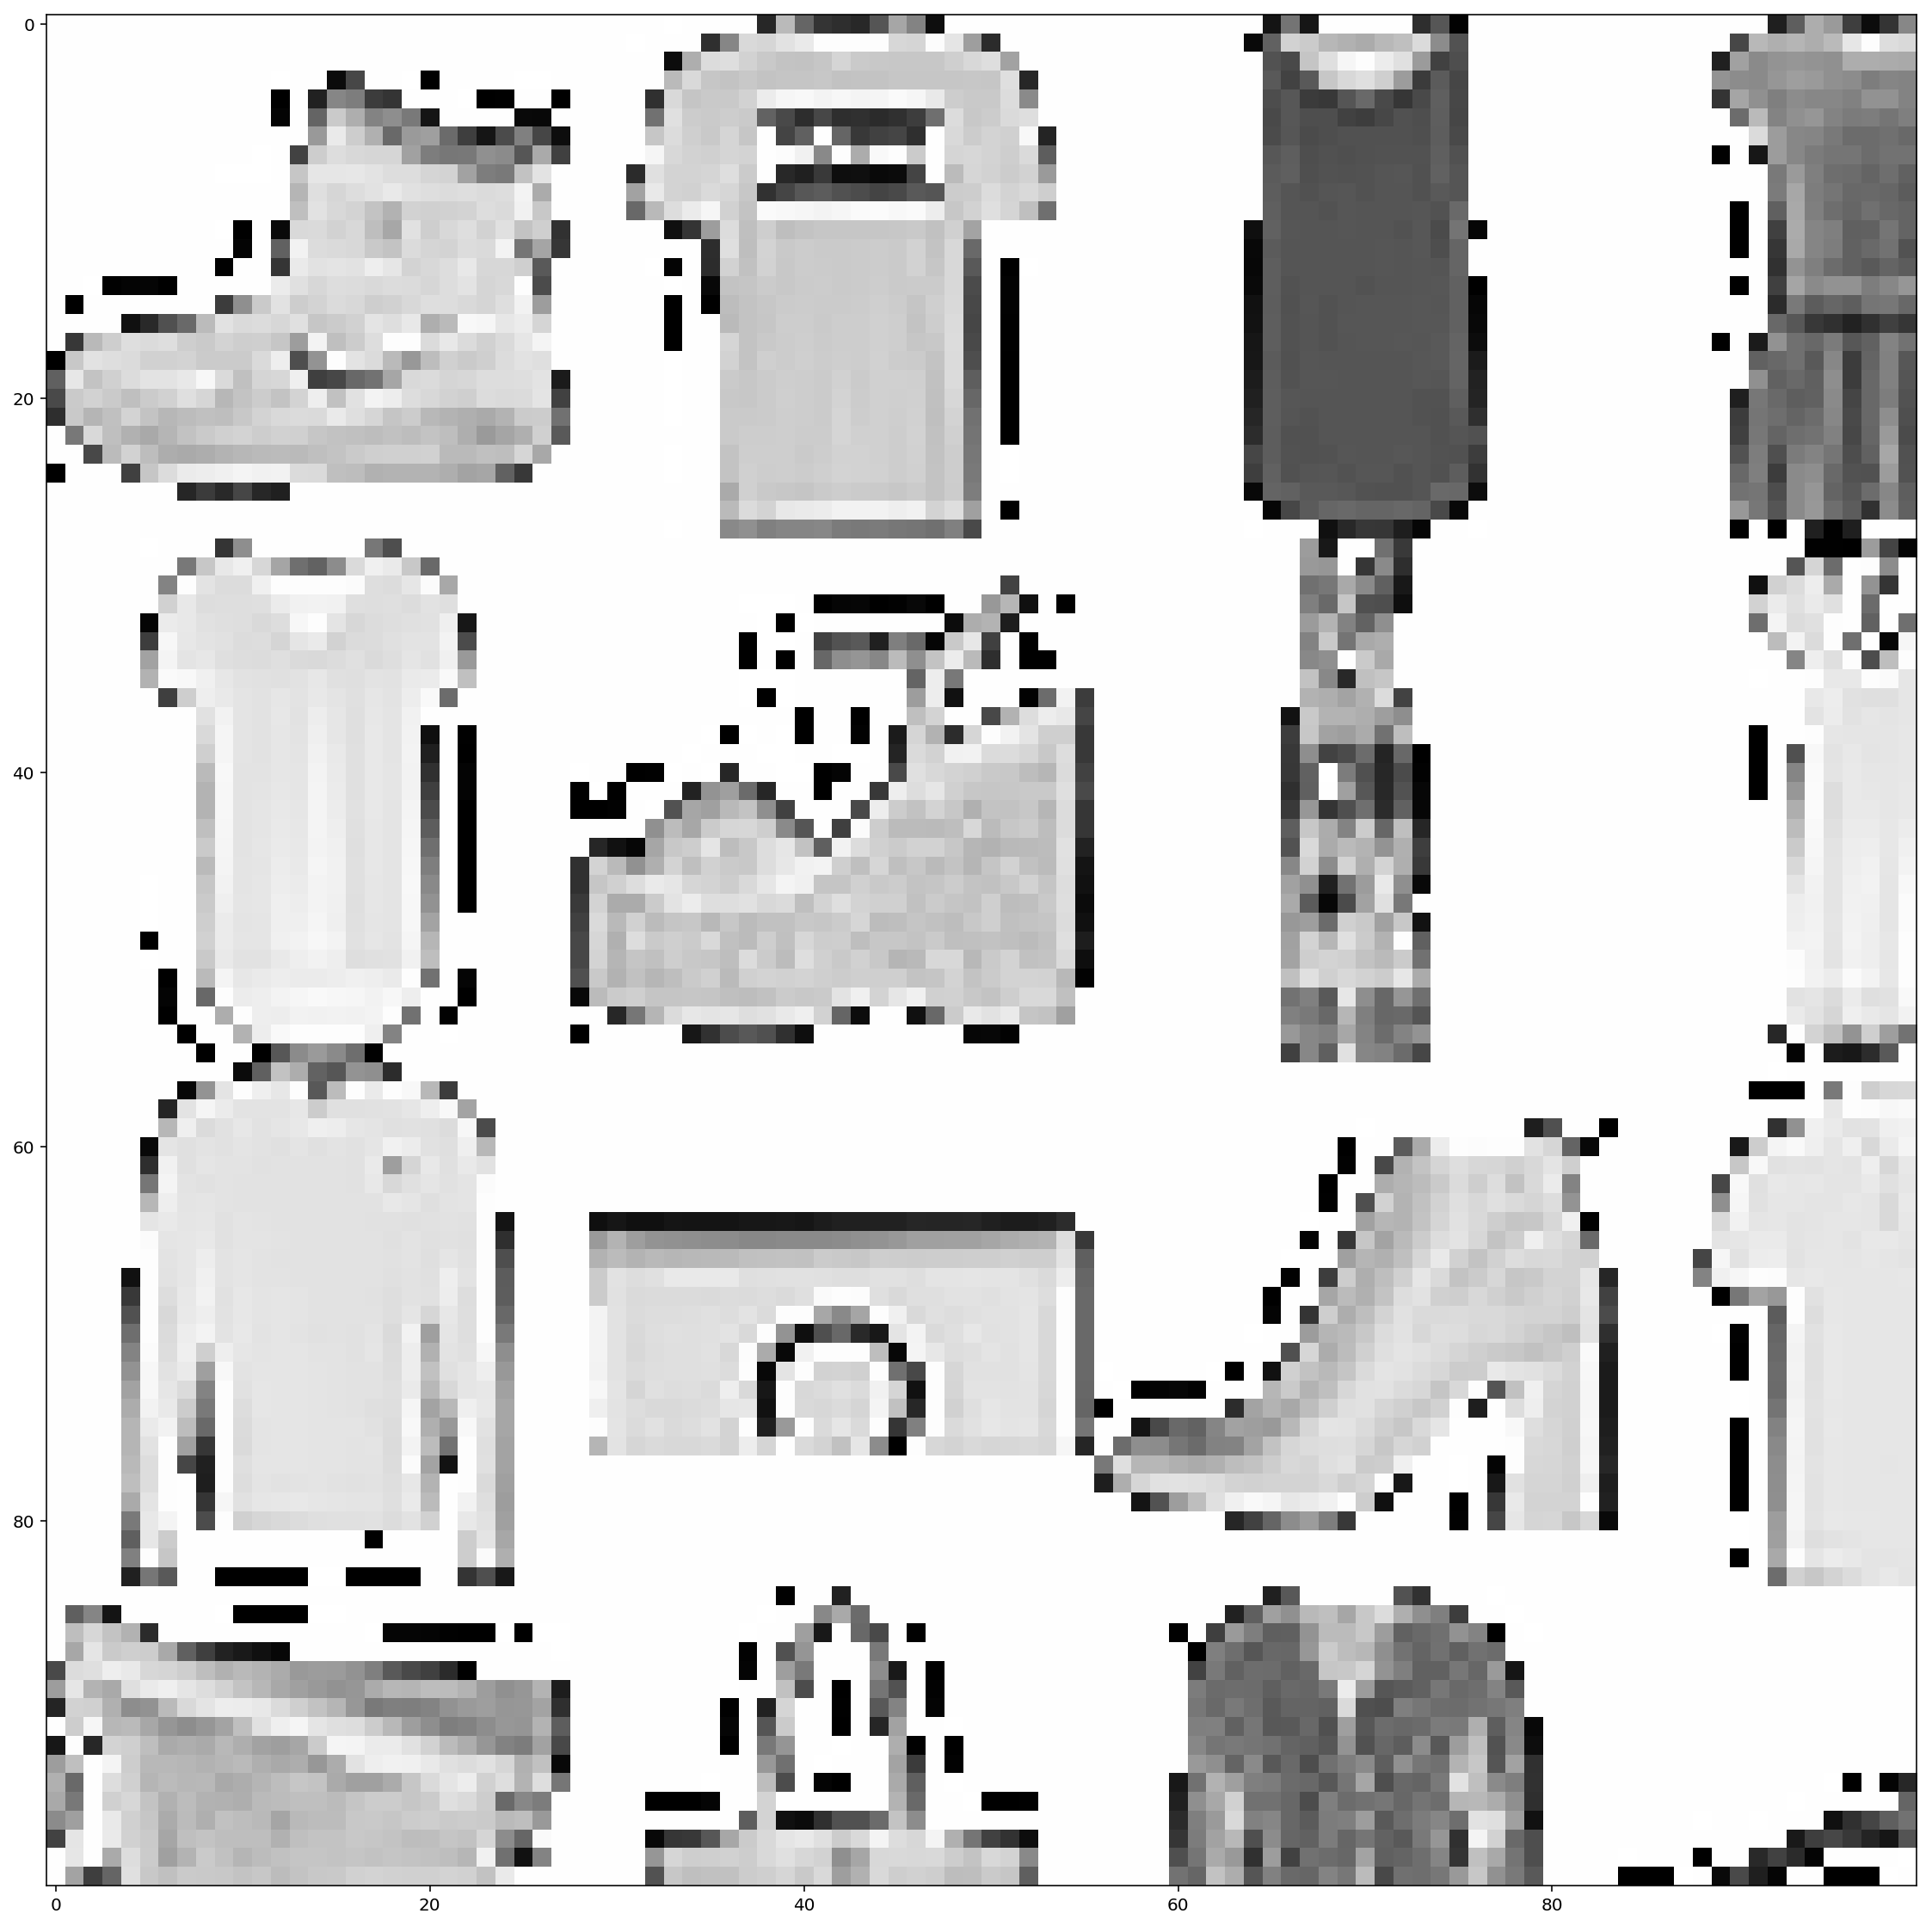

In [25]:
to_visualise = train_images
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.figure(figsize= (20,20))
plt.imsave(path_to_fmnist_sprites,sprite_image,cmap='binary')
plt.imshow(sprite_image[:100,:100],cmap='binary')

## Create metadata

In [26]:
with open(path_to_fmnist_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(word_labels):
        f.write("%d\t%s\n" % (index,label))

## Create Embedding

In [27]:
embedding = tf.Variable(train_images, trainable=False, name = 'fashion')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'fashion'

# Specify where you find the metadata
embedding.metadata_path = path_to_fmnist_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_to_fmnist_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

## Save model 

In [ ]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run(session = sess)
saver = tf.train.Saver()
config.model_checkpoint_path = os.path.join(LOG_DIR,'fashion.ckpt')
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'projector/model.ckpt-1'

# Model Training

In [ ]:
size, num_features = train_images.shape
batch_size = 64
epochs = 2
num_iterations = size//batch_size
test_step = 5

with tf.device('/gpu:0'):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess: 
        tf.global_variables_initializer().run(session = sess)
        for i in range(num_iterations*epochs):
            offset = (i*batch_size)% size
            batch_x = x_train[(offset):(offset+batch_size),:]
            batch_y = y_train[offset:(offset+batch_size),:]


            summary, _,loss = sess.run([merged, optimizer,cost],feed_dict={x: batch_x, y: batch_y})
            train_writer.add_summary(summary,i)
            if i % 100 == 0:

                print('Epoch {:<3} - Training Loss: {}'.format(i,loss))

        for i in range(test_step):
            if i % 10 == 0:
                summary, test_accuracy = sess.run([merged,accuracy],feed_dict={x: x_test, y: y_test})
                test_writer.add_summary(summary, i)
                print('Test accuracy at step %s: %s' % (i, test_accuracy))

Epoch 0   - Training Loss: 2.30072021484
Epoch 100 - Training Loss: 2.32363080978
Epoch 200 - Training Loss: 2.33249115944
Epoch 300 - Training Loss: 2.36859750748
Epoch 400 - Training Loss: 2.33826136589
